# MLP on MCR & MT Data

11 - 04 - 2023 | Best MAPE = 12.2

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
file = r'/content/drive/MyDrive/Colab/mlp-mcr/dataset.csv'

Data

In [26]:
import pandas as pd
import numpy as np

df = pd.read_csv(file)

# dataset
dataset = df.values
X = dataset[:, 6] # mt column
print(np.min(X)," ",np.max(X))
print(len(X))
Y = dataset[:, 5] # mcr column
print(np.min(Y)," ",np.max(Y))
print(len(Y))

0.01   5858.833333333333
179996
0.0253444780071999   4874.2
179996


Correlation

In [27]:
from scipy.stats import pearsonr

corr, _ = pearsonr(X, Y)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.752


Scatter

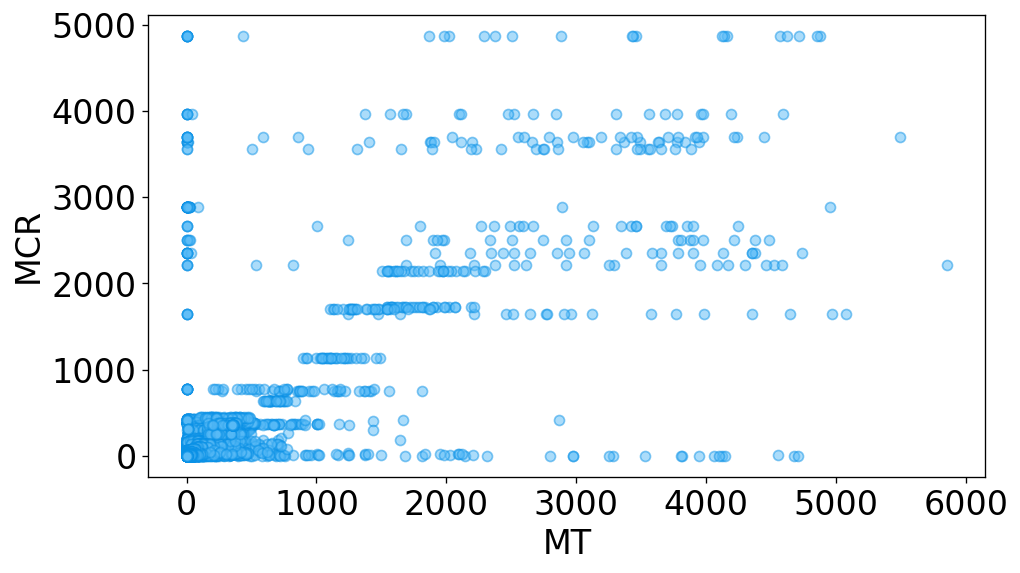

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 5), dpi=120)
plt.scatter(x=X, y=Y, color="#59bbf7", marker="o",alpha=0.5, edgecolors="#0991e6")
plt.subplot().tick_params(labelsize=20)
plt.xlabel('MT', fontsize=20)
plt.ylabel('MCR', fontsize=20)
plt.show()

Reshape + Split

In [29]:
X = X.reshape(-1, 1)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=1)

print(len(X_train), len(Y_train))

134997 134997


Multilayer Perceptron Regression Model

In [30]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(100,100,100),
                   activation="relu",
                   solver="adam",
                   alpha=0.001,
                   learning_rate="adaptive",
                   learning_rate_init=0.00005,
                   max_iter=7000)

Model Evaluation

In [31]:
from sklearn.model_selection import GridSearchCV

# The results of this grid search have been used in the mlp model.
"""
# params
param_grid = {
    "hidden_layer_sizes": [(10,), (50,), (100,)],
    "activation": ["relu", "tanh"],
    "solver": ["adam", "sgd"],
    "learning_rate": ["constant", "adaptive"],
    'alpha': [0.00001, 0.0001, 0.001, 0.01],
    }

# create GridSearchCV object
grid = GridSearchCV(mlp, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)

# fit the grid search object to the data
grid.fit(X_train, Y_train)

# print the best parameters and score
print("Best parameters: ", grid.best_params_)
"""

'\n# params\nparam_grid = {\n    "hidden_layer_sizes": [(10,), (50,), (100,)],\n    "activation": ["relu", "tanh"],\n    "solver": ["adam", "sgd"],\n    "learning_rate": ["constant", "adaptive"],\n    \'alpha\': [0.00001, 0.0001, 0.001, 0.01],\n    }\n\n# create GridSearchCV object\ngrid = GridSearchCV(mlp, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)\n\n# fit the grid search object to the data\ngrid.fit(X_train, Y_train)\n\n# print the best parameters and score\nprint("Best parameters: ", grid.best_params_)\n'

Preprocess + Fit + Predict

In [32]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipe = make_pipeline(StandardScaler(), mlp)
pipe.fit(X_train, Y_train)
Y_predict = pipe.predict(X_test)

Plot

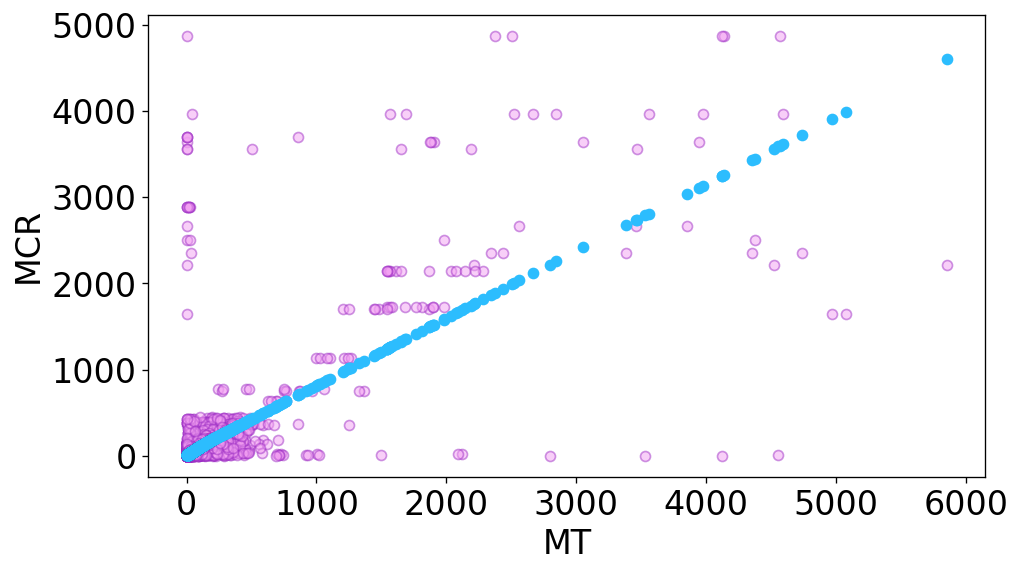

In [33]:
# plot
plt.figure(figsize=(9, 5), dpi=120)
plt.scatter(x=X_test, y=Y_test, color="#F3A0F2", marker="o",alpha=0.5, edgecolors="#9D2EC5")
plt.subplot().tick_params(labelsize=20)
plt.scatter(x=X_test, y=Y_predict, color="#2CBDFE", linewidth=1)
plt.ylabel('MCR', fontsize=20)
plt.xlabel('MT', fontsize=20)
plt.show()

Error

In [34]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
print("MAPE : ", mean_absolute_percentage_error(Y_test, Y_predict))
print("MAE : ", mean_absolute_error(Y_test, Y_predict))

MAPE :  13.44184831208812
MAE :  11.332503629923123


Graph

27.321338148527794    27.959242534987467


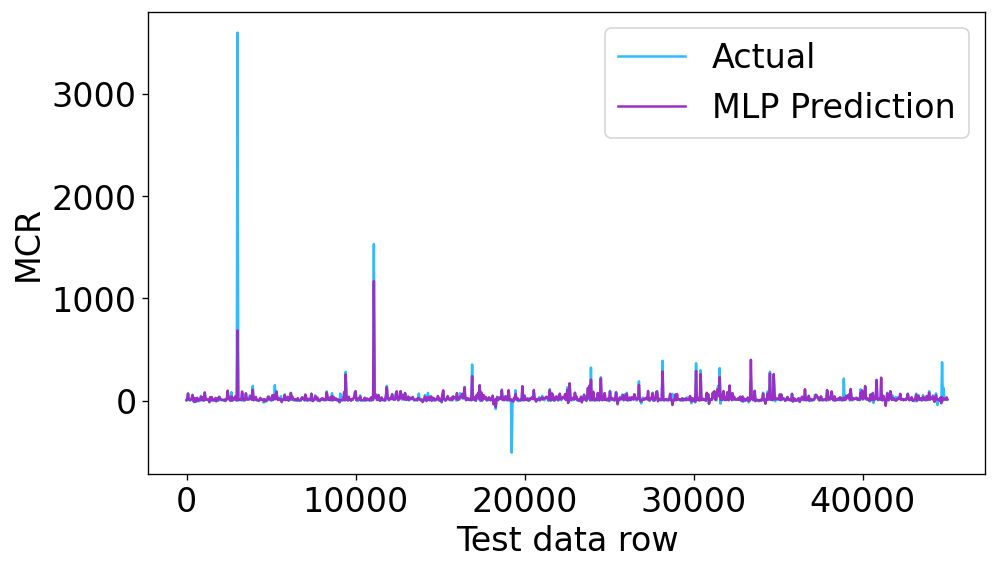

In [35]:
from scipy.interpolate import make_interp_spline

print(np.mean(Y_predict), "  ", np.mean(Y_test))
plt.figure(figsize=(9, 5), dpi=120)
X_Y_Spline = make_interp_spline(np.arange(44999), Y_test)
# Returns evenly spaced numbers
# over a specified interval.
X_ = np.linspace(np.arange(44999).min(), np.arange(44999).max(), 1000)
Y_ = X_Y_Spline(X_)
 
plt.plot(X_,Y_, label='Actual', color="#2CBDFE")
X_Y_Spline = make_interp_spline(np.arange(44999), Y_predict)
X_ = np.linspace(np.arange(44999).min(), np.arange(44999).max(), 1000)
Y_ = X_Y_Spline(X_)
plt.plot(X_,Y_,  label='MLP Prediction',color="#9D2EC5")
plt.subplot().tick_params(labelsize=20)
plt.ylabel('MCR', fontsize=20)
plt.xlabel('Test data row', fontsize=20)
plt.legend(fontsize=20)
plt.show()